# Dealing with multiple Radial Velocity measurements

# Authors
Alex Binks, Moritz Guenther

# Learning goals
- Input/Output: Read an ascii file of tabulated data and output a results file using [astropy.io.ascii](https://docs.astropy.org/en/stable/io/ascii/index.html).
- Coding: Produce reusable codes with functions. Apply matrix operations using numpy.
- Science: Learn how to detect stars as components of multiple stellar systems through radial velocity (RV) variations and measure error-weighted RVs.
- Visualisation: Plot histograms using matplotlib.

# Keywords
radial velocity, multiple stars, astropy.io, numpy, matrix operations, error propagation

# Summary
It is a common task in astronomy to calculate a final measured quantity (and error) when there are multiple individual measurements for a particular object. If the measurement errors are similar in magnitude, one might choose an error weighted average. In other cases where there are large and small error bar it may be better to simply use the quantity corresponding to the lowest error.

This is often the case when dealing with radial velocities (RVs) for stars, which (as the name suggests) measures the velocity in the line-of-sight of the observer (positive value are receeding from the observer). In the era of large spectroscopic surveys such as RAVE, Gaia DR2 (soon to be DR3) and GALAH, correct RV measurements are crucial to properly interpret data for millions of stars. When combined with positions, proper motions (the angular displacement on the sky per year) and distance measurements, a full 6D spatio-kinematic map of the star can be produced. Three examples of how RV measurements can be utilised are:

1. Determine membership status for candidate members of comoving clusters and groups.
2. Traceback the orbits of stars through the Galaxy
3. reveal the large-scale kinematic structure of the Milky Way.

We also know that approximately half of all stars belong in multiple systems, and depending on their orbital properties (e.g., physical separation, eccentricity, inclination), their multiplicity status is given away by the fact that the components vary in RV, typically between 1-100 km/s. Whilst obvious temporal changes in RV are a giveaway for identifying multiples, it should be noted there is always some (usually small) probability that multiple systems evade detection because they are observed at the same orbital phase!

### With this in mind, the following program:

- reads in a table of RV measurements for any set of stars
- makes a decision on whether the star is multiple or likely single
- calculates a final RV from the individual measurements.

### Some points before we begin:

1. Table rows consist of a star identifier (that must be exactly the same if multiple entries are present), a reference to the source catalogue, the RV, and the RV error.

2. For the cases where no RV error is calculated (tut, tut), for lack of a better method, we have assumed this error to be twice the median error bar from the whole sample of RV measurements. It is the user's discretion whether or not to include data that are missing errors (but sometimes even these measurements have intrinsic value if, say, there are no other measurements).

3. The confidence placed in the reliability of each RV measurement is equal regardless of provenance.

4. The physical maximum RV difference for an equal mass binary system is $\Delta RV_{\rm max} \geq 437\times\frac{\sqrt{M/M_{\odot}}}{\sqrt{a/R_{\odot}}}$ km/s -- [Bowers & Deeming 1984](https://adswww.harvard.edu/abs/1984astr.book.....B). We discard these RV outiers from analysis when considering the multiplicity status and measuring the final RV.

### Part 1: Reading in the catalogue and pre-cleaning

Import python modules

In [282]:
from astropy.table import unique, Table
from astropy.io import ascii
import numpy as np

from matplotlib import pylab as plt

np.set_printoptions(precision=3, suppress=True)

%matplotlib inline

Read in the input file
The minimum requirement is;
- name
- RV
- eRV
- reference

Currently the following line would read in a basic ascii (space-separated)
file, but "ascii.read" can take all kinds of formats, which are described
in: https://docs.astropy.org/en/stable/io/ascii/read.html


In [283]:
f_in = ascii.read("AllRVs.dat", format='basic', delimiter=' ', guess=False)

In [284]:
f_in

name,cat,d_as,RV,eRV
str19,str27,float64,float64,float64
J000000.00-000000.0,Dummy1,0.0,10.0,0.5
J000000.00-000000.0,Dummy1,0.0,10.2,0.4
J000000.00-000000.0,Dummy1,0.0,10.3,0.5
J000000.00-000000.0,Dummy1,0.0,10.1,0.3
J000000.00-000000.0,Dummy1,0.0,10.5,0.5
J000000.00-000000.0,Dummy1,0.0,1000.0,0.5
...,...,...,...,...
J234326.88-344658.5,III/283/ravedr6,1.017,8.47,3.12
J234326.88-344658.5,J/A+A/649/A6/table1c,0.91,8.529,3.114


Locate the indices for measurements without RV errors. 

In [285]:
ind = f_in['eRV'] < -99

In [286]:
ind.sum()

10

In [287]:
f_in[ind]

name,cat,d_as,RV,eRV
str19,str27,float64,float64,float64
J025154.17+222728.9,J/A+A/612/A49/tableb1,1.46,-18.849,-999.0
J050827.31-210144.3,J/A+A/612/A49/tableb1,0.21,33.752,-999.0
J062047.17-361948.2,J/MNRAS/447/1267/table1,0.11,16.5,-999.0
J075830.92+153013.4,III/198/main,2.0,18.0,-999.0
J112105.43-384516.6,J/MNRAS/494/2429/table1,0.74,10.85,-999.0
J114728.37+664402.7,J/A+A/612/A49/tableb1,1.16,-9.543,-999.0
J173353.07+165511.7,J/A+A/612/A49/tableb1,1.74,-22.484,-999.0
J210708.43-113506.0,J/MNRAS/494/2429/table1,1.05,-9.515,-999.0
J224500.20-331527.2,J/AJ/154/69/table4,2.03,2.0,-999.0


In case of missing errors, use 2x the median error from all observations. In our example missing errors are marked as "-999". Please modify this line to make sense of your own dataset.

In [288]:
f_in["eRV"][f_in["eRV"] < -99] = 2.0 * np.median(f_in["eRV"][~ind])

In [289]:
f_in

name,cat,d_as,RV,eRV
str19,str27,float64,float64,float64
J000000.00-000000.0,Dummy1,0.0,10.0,0.5
J000000.00-000000.0,Dummy1,0.0,10.2,0.4
J000000.00-000000.0,Dummy1,0.0,10.3,0.5
J000000.00-000000.0,Dummy1,0.0,10.1,0.3
J000000.00-000000.0,Dummy1,0.0,10.5,0.5
J000000.00-000000.0,Dummy1,0.0,1000.0,0.5
...,...,...,...,...
J234326.88-344658.5,III/283/ravedr6,1.017,8.47,3.12
J234326.88-344658.5,J/A+A/649/A6/table1c,0.91,8.529,3.114


The maximum possible RV difference between two observations, $\Delta RV_{\rm max}$ was given earlier (point 4). One may wish to include columns in their input table of estimated mass and radius. In our case we are dealing mainly with  early K-type pre-main sequence stars: mass = $0.8M_{\odot}$ and radius = $0.7R_{\odot}$.


In [290]:
mass, radius = 0.8, 0.7
d_max = 437.*np.sqrt(mass)/np.sqrt(radius)

Now we want to measure the differences in RV between each measurement to test for multiplicity. The condition is set as follows:

$\Delta RV > \zeta\times (\sigma_{RV_{1}} + \sigma_{RV_{2}})$, where $\zeta = 3.0$ (but this can be altered).

In practice, this is done with a function called "test_mult".

First we create a square matrix of RV measurements where the n observations are repeated over n rows. A matrix of RV differences, $c$, is calculated by subtracting this matrix by its transpose.

Next we remove any measurements that cause $\Delta RV > \Delta RV_{\rm max}$ by locating their position in the numpy array (np.where) and deleting them (np.delete). Then the matrix $c$ is recalculated (without the outliers).

The combined errors ($\sigma_{RV_{1}} + \sigma_{RV_{2}}$) are found in a similar way, where the n errors are repeated over n rows. The corresponding error matrix, $e_c$, is found by calculating the sum of the corresponding error matrix and its transpose.

Since the matrix has repeating values (and zeroes along the diagonal), we extract the subset of matrix elements that have $c > 0$. If any of these elements satisfy $\frac{c}{e_c} > \zeta$, the star is flagged as a probable multiple, otherwise it is likely single.

In [362]:
def test_mult(trv, erv):
    c = trv[:, None] - trv[None, :]
    ee = c > d_max
    x = np.array(np.where(ee))[0]
    if len(x) > 0:
        trv = np.delete(trv, x[0], 0)
        erv = np.delete(erv, x[0], 0)
    c = trv[:, None] - trv[None, :]
    ec = np.abs(erv[:, None] + erv[None, :])
    ratio = c / ec
    ind = (c > 0)
    return (ratio[ind] > 3).sum(), len(ind)

Group together RV measurements by using the group_by function in astropy tables.

In [369]:
obs_by_name = f_in.group_by('name')
obs_by_name

name,cat,d_as,RV,eRV
str19,str27,float64,float64,float64
J000000.00-000000.0,Dummy1,0.0,10.0,0.5
J000000.00-000000.0,Dummy1,0.0,10.2,0.4
J000000.00-000000.0,Dummy1,0.0,10.3,0.5
J000000.00-000000.0,Dummy1,0.0,10.1,0.3
J000000.00-000000.0,Dummy1,0.0,10.5,0.5
J000000.00-000000.0,Dummy1,0.0,1000.0,0.5
...,...,...,...,...
J234326.88-344658.5,III/283/ravedr6,1.017,8.47,3.12
J234326.88-344658.5,J/A+A/649/A6/table1c,0.91,8.529,3.114


Create a results table for each unique star entry and print the multiplicity status returned from the test_mult function. Here "n_comp", "n_mult" and "ismult" refer to the number of observations used, the number of times a binary was flagged when comparing each measurement and the multiplicity status.

In [374]:
results = obs_by_name.groups.keys
x = [test_mult(t['RV'], t['eRV']) for t in obs_by_name.groups]
results['n_comp'] = [o[1] for o in x]
results['n_mult'] = [o[0] for o in x]
results['ismult'] = ['yes' if n > 0 else 'no' for n in results['n_mult']]

In [375]:
results

name,n_comp,n_mult,mult?,ismult
str19,int64,int64,str3,str3
J000000.00-000000.0,5,0,no,no
J000453.05-103220.0,1,0,no,no
J001527.62-641455.2,4,0,no,no
J001536.79-294601.2,5,3,yes,yes
J001552.28-280749.4,2,0,no,no
J001555.65-613752.2,1,0,no,no
...,...,...,...,...
J234243.45-622457.1,1,0,no,no
J234326.88-344658.5,2,0,no,no


Next, define a function named "selectrv" to calculate the final RV and error.

Firstly, remove any stars that cause $\Delta RV > \Delta RV_{\rm max}$, then measure the final RV (and error) in the following way:

1. If the standard deviation in the error bars is less than the standard deviation in the measurements, then take the inverse weighted mean, using the square of the error bars as weights.
2. Otherwise, adopt the final RV as the value corresponding to the lowest error bar.


In [377]:
def selectrv(trv, erv):
    c = trv[:, None] - trv[None, :]
    ee = c > d_max
    x = np.array(np.where(ee))[0]
    if len(x) > 0:
        trv = np.delete(trv, x[0], 0)
        erv = np.delete(erv, x[0], 0)
    if (trv.std() > erv.std()):
        return np.average(trv, weights=erv**-2), np.sqrt(1./np.sum(erv**-2))
    else:
        return trv[np.argmin(erv)], erv[np.argmin(erv)]

Call the "selectrv" function for each set of RV observations and print to the results table.

In [378]:
out = [selectrv(t['RV'], t['eRV']) for t in obs_by_name.groups]
results['RV'] = [o[0] for o in out]
results['eRV'] = [o[1] for o in out]

Format the results table so there are a sensible number of significant figures for the RV and eRV columns.

In [379]:
results['RV'].format = '{:.2f}'
results['eRV'].format = '{:.2f}'
results[0:9]

name,n_comp,n_mult,mult?,ismult,RV,eRV
str19,int64,int64,str3,str3,float64,float64
J000000.00-000000.0,5,0,no,no,10.19,0.18
J000453.05-103220.0,1,0,no,no,7.70,13.40
J001527.62-641455.2,4,0,no,no,6.70,0.30
J001536.79-294601.2,5,3,yes,yes,0.42,0.61
J001552.28-280749.4,2,0,no,no,0.25,0.62
J001555.65-613752.2,1,0,no,no,19.90,0.70
J001709.96+185711.8,2,0,no,no,32.98,0.59
J001723.69-664512.4,5,0,no,no,10.70,0.19
J002101.27-134230.7,1,0,no,no,1.25,0.81


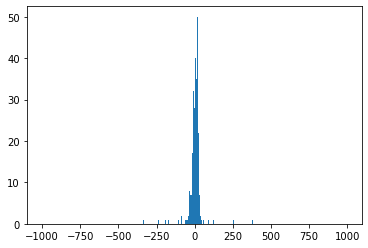

In [391]:
plt.hist(results['RV'], bins=np.arange(-1000,1000,5))
plt.show()